##**Exploratory Data Analysis**

In this notebook, we conduct thorough analyses to understand our dataset's structure, patterns, and relationships.

1. **Class imbalance**\
Examine how our target variable is distributed across different classes. This analysis reveals the need for oversampling techniques to address any imbalances and improve model performance.

2. **Target variable against time**\
Investigate how our target variable relates to time to uncover any seasonal trends. This exploration helped us decide whether to include time-related features in our models (e.g., season, day of the week).

3. **(Partial) Autocorrelations**\
Explore whether features exhibit any time dependencies. This analysis suggests the importance of lagging features to capture temporal patterns effectively.

4. **Feature Exploration**\
Thoroughly understand our dataset's features using simple techniques like data visualization, outlier detection, and examining feature distribution and correlation.

In [1]:
# import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import datetime as dt
import matplotlib
import statsmodels.api as sm
import scipy.stats as ss

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.inspection import permutation_importance
#from sklearn.model_selection import TimeSeriesSplit, cross_val_score
#from sklearn.ensemble import RandomForestClassifier
#from imblearn.over_sampling import SMOTE
#from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline

In [2]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# searching for files, load data and convert index to datetime type

def search_file(directory, filename):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return os.path.join(root, filename)
    return None

search_directory = '/content/drive/My Drive'
file_name = 'curtailment_target_features.csv'
file_path = search_file(search_directory, file_name)

df = pd.read_csv(file_path, sep = ';', index_col=0)
df.index = pd.to_datetime(df.index)

##**1. Class Imbalance**

By counting the bivariate target variable, it becomes clear that the case of curtailment occurs significantly less frequently than no curtailment.

redispatch
0.0    131810
1.0      8398
Name: count, dtype: int64


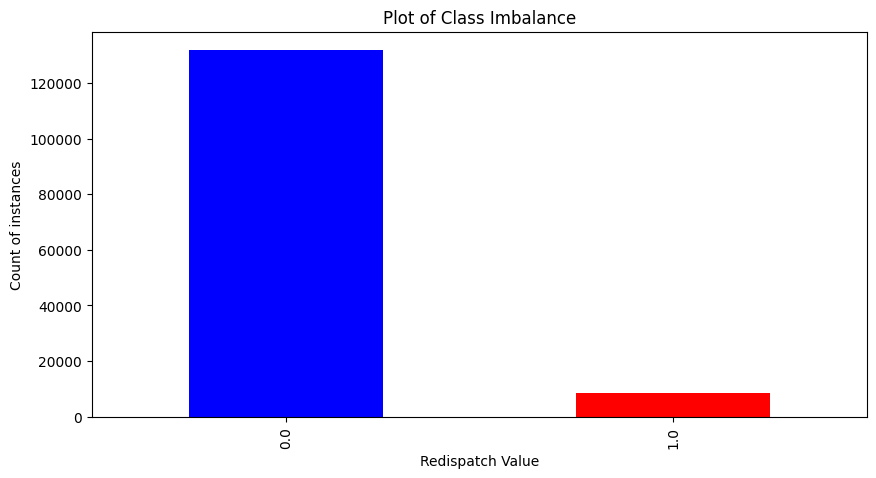

In [4]:
# number count
print(df.redispatch.value_counts())

# plot
df.redispatch.value_counts().plot(kind='bar', figsize=(10, 5), color=['blue', 'red'])
plt.xlabel('Redispatch Value')
plt.ylabel('Count of instances')
plt.title('Plot of Class Imbalance')
plt.show()

##**2. Target variable against time**

Looking at when redispatch occurs over time, there is no regularity or pattern over the year, the week or the day.


**Redispatch values over time**

In [5]:
def redispatch_time_plot(df, start_date, end_date):
  """ plots the redispatch status agaist the specified timeframe """
  start_date = start_date
  end_date = end_date
  df_selected = df.loc[start_date:end_date]
  df_selected['redispatch'].plot(figsize=(10, 5))
  plt.gcf().autofmt_xdate()
  plt.xlabel('Date')
  plt.ylabel('Redispatch')
  plt.title('Redispatch over time')
  plt.show()


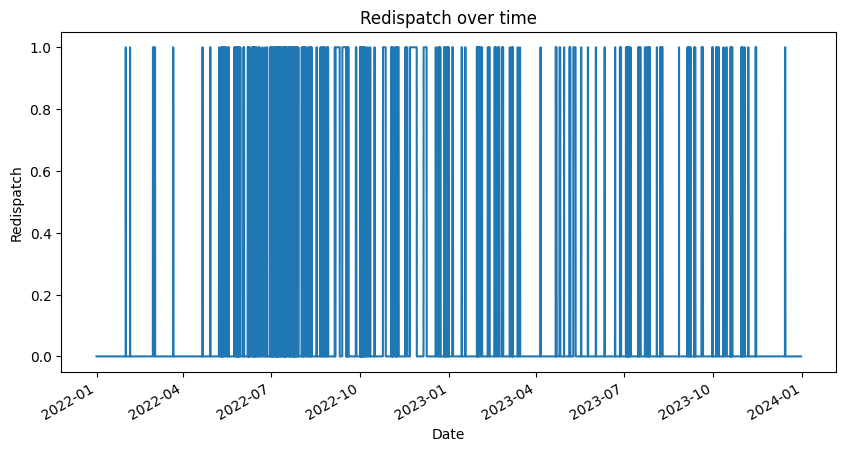

In [6]:
# over a year
redispatch_time_plot(df, '2022-01-01', '2023-12-31')

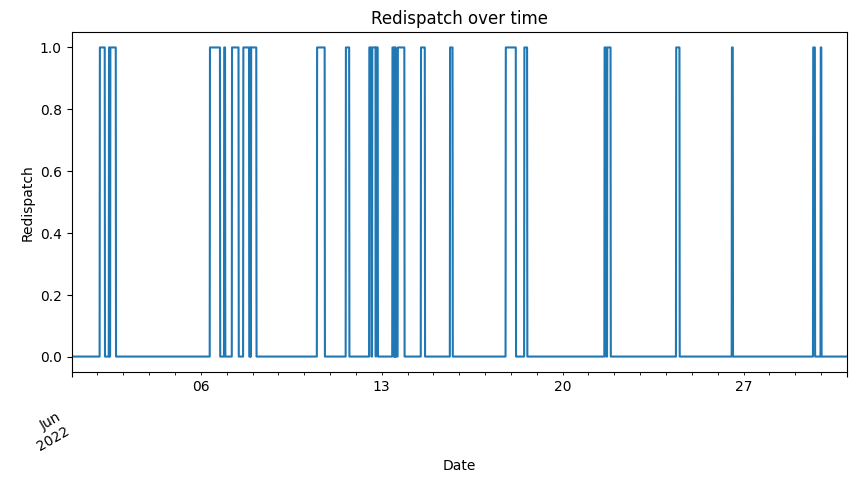

In [7]:
# over a month
redispatch_time_plot(df, '2022-06-01', '2022-06-30')

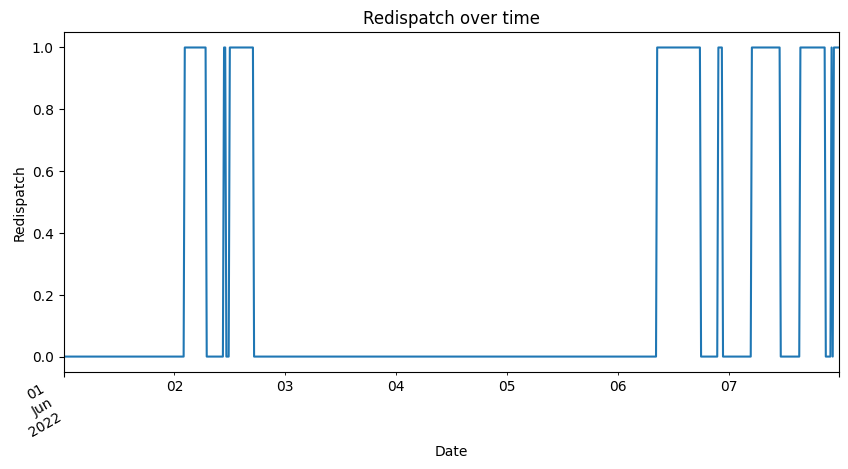

In [8]:
# over a week
redispatch_time_plot(df, '2022-06-01', '2022-06-07')

**Summary Statistics over time**

In [9]:
def redispatch_stats_plot(df, interval):
  """Calculates the summary statistics of the given time interval and plots it over time."""
  summary = df['redispatch'].resample(interval).agg(['mean', 'median', 'var'])
  summary.plot(title='Summary Statistics', figsize=(10, 5))
  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.legend(['Mean', 'Median', 'Variance'])

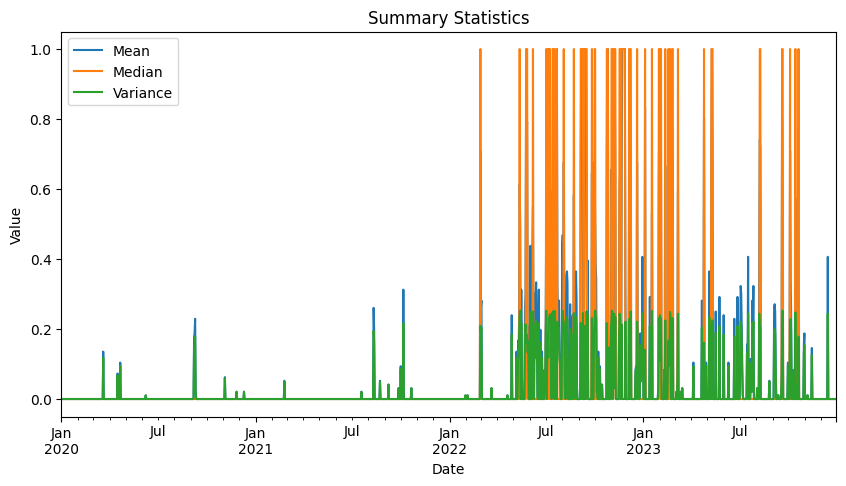

In [10]:
# daily
redispatch_stats_plot(df, 'D')

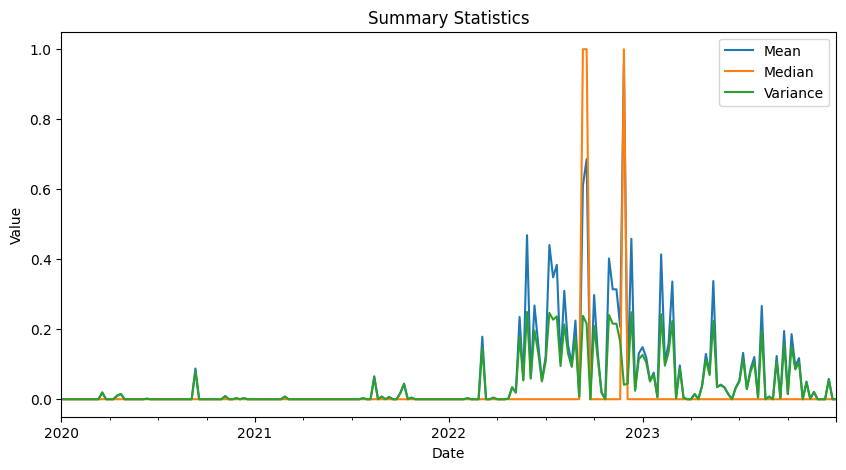

In [11]:
# weekly
redispatch_stats_plot(df, 'W')

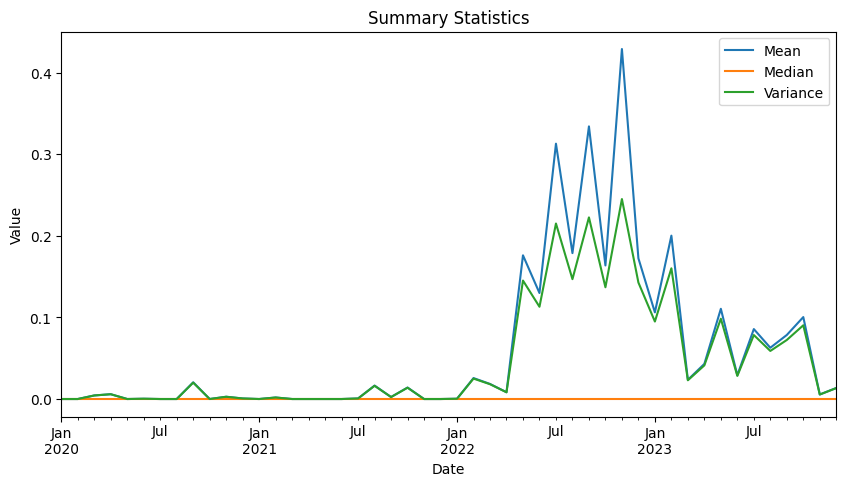

In [12]:
# weekly
redispatch_stats_plot(df, 'M')

##**3. (partial) Autocorrelations**

**Autocorrelation:** measures the degree of similarity between a time series and a lagged version of itself over successive time intervals.

**Partial autocorrelation:** measures the correlation between a variable and a lagged version of itself, controlling for the intervening lags. It quantifies the relationship between two observations in a time series while removing the influence of the intermediate observations.

**1. Autocorrelation**

In [13]:
# Calculate autocorrelation function (ACF)
acf = pd.Series(data=df['redispatch']).autocorr()
print("Autocorrelation:", acf)

Autocorrelation: 0.960101247666363


<Figure size 1000x600 with 0 Axes>

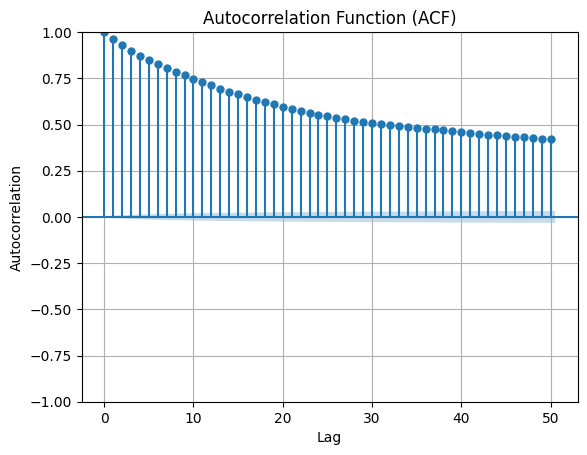

In [14]:
# plot
plt.figure(figsize=(10, 6))
plot_acf(df['redispatch'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)

**1. partial Autocorrelation**

In [ ]:
# Plot partial autocorrelation function for each feature
for feature in df.columns:
    plt.figure(figsize=(12, 6))
    plot_pacf(df[feature], lags=10)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title(f'Partial Autocorrelation Plot for {feature}')

##**4. Features**

**Pairwise Scatterplots:** scatterplots for pairs of variables to visually explore their relationships and identify potential patterns or trends.

**Correlation Matrix:** correlation coefficients among variables to assess their degree of association. This helps identify highly correlated pairs, which may indicate redundant or multicollinear variables.

**Variance Inflation Factor (VIF):** quantify multicollinearity. VIF measures the extent to which the variance of an estimated regression coefficient increases if predictors are correlated. High VIF values indicate that a predictor may be too highly correlated with other predictors in the model, potentially leading to multicollinearity issues.

**Principal Component Analysis (PCA):** transform the variables into a set of orthogonal principal components. PCA helps reduce the dimensionality of the dataset while preserving most of its variance, facilitating interpretation and modeling.

In [16]:
features = df.drop('redispatch', axis=1)

**1. Pairwise Scatterplots**

In [ ]:
# pairwise Scatterplots
sns.pairplot(features)
plt.show()

**2. Correlation Matrix**

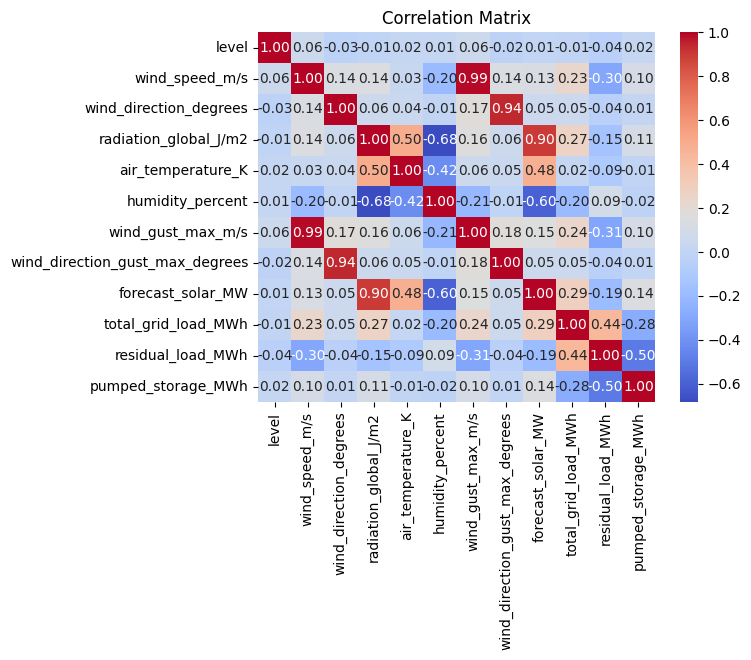

In [18]:
# correlation Matrix
correlation_matrix = features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**3. VIF Diagnostic**

In [19]:
# VIF Diagnostic
X_with_const = add_constant(features)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)


                            Feature          VIF
0                             const  3105.630084
1                             level     1.007630
2                    wind_speed_m/s    44.255519
3            wind_direction_degrees     9.205091
4             radiation_global_J/m2     6.174555
5                 air_temperature_K     1.457142
6                  humidity_percent     1.980635
7                 wind_gust_max_m/s    45.489999
8   wind_direction_gust_max_degrees     9.221676
9                 forecast_solar_MW     5.689605
10              total_grid_load_MWh     1.977689
11                residual_load_MWh     2.157219
12               pumped_storage_MWh     1.375341


**4. Principal Component Analysis (PCA)**

Explained Variance Ratio: [9.99993811e-01 3.93672327e-06 1.15696739e-06 1.00647335e-06
 3.95766203e-08 3.14648774e-08 7.58854931e-09 5.11205030e-09
 2.04161254e-09 1.49993141e-09 1.05397100e-09 7.73730669e-12]


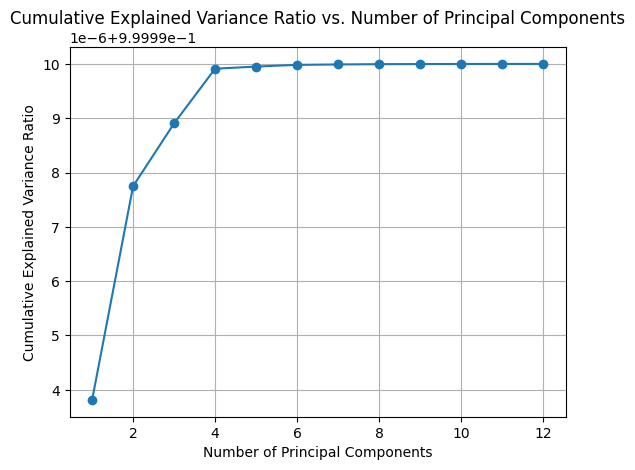

Principal Component 1: Top Features - ['radiation_global_J/m2', 'total_grid_load_MWh', 'residual_load_MWh', 'forecast_solar_MW', 'humidity_percent']
Principal Component 2: Top Features - ['residual_load_MWh', 'total_grid_load_MWh', 'pumped_storage_MWh', 'wind_direction_gust_max_degrees', 'wind_direction_degrees']
Principal Component 3: Top Features - ['total_grid_load_MWh', 'wind_direction_degrees', 'wind_direction_gust_max_degrees', 'residual_load_MWh', 'wind_gust_max_m/s']
Principal Component 4: Top Features - ['total_grid_load_MWh', 'wind_direction_gust_max_degrees', 'wind_direction_degrees', 'residual_load_MWh', 'forecast_solar_MW']
Principal Component 5: Top Features - ['pumped_storage_MWh', 'residual_load_MWh', 'humidity_percent', 'forecast_solar_MW', 'air_temperature_K']
Principal Component 6: Top Features - ['wind_direction_gust_max_degrees', 'wind_direction_degrees', 'pumped_storage_MWh', 'air_temperature_K', 'humidity_percent']
Principal Component 7: Top Features - ['humidity

In [20]:
# Principal Component Analysis (PCA)

# Calculate explained variance ratio
pca = PCA().fit(features)
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Plot cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Obtain loadings and identify top features for each principal component
top_n_features = 5
loadings = pca.components_
for i, component in enumerate(loadings):
    top_feature_indices = np.argsort(np.abs(component))[::-1][:top_n_features]
    top_features = [features.columns[idx] for idx in top_feature_indices]
    print(f"Principal Component {i + 1}: Top Features - {top_features}")

**ANOVA**

statistical method to pinpoint significant features by analyzing how a numerical variable varies across different categories of a categorical variable. It calculates the F-statistic to assess the difference in means between groups. A low p-value suggests at least one group's mean significantly differs from others, rejecting the null hypothesis of no difference.

In [ ]:
def anova_pvalues(df, cat_col, num_cols):
    """
    This function calculates the ANOVA p-values (probability of no correlation)
    between a categorical column and multiple numerical columns of a DataFrame.
    """
    p_values = {}
    for num_col in num_cols:
        CategoryGroupLists = df.groupby(cat_col)[num_col].apply(list)
        AnovaResults = ss.f_oneway(*CategoryGroupLists)
        p_value = round(AnovaResults[1], 3)
        p_values[num_col] = p_value

    return p_values

In [ ]:
numeric_columns = features.columns
p_values = anova_pvalues(df, 'redispatch', numeric_columns)

# Print the p-values for each numeric column
for num_col, p_value in p_values.items():
    print(f"p-value {num_col}: {p_value}")

p-value level: 0.0
p-value wind_speed_m/s: 0.0
p-value wind_direction_degrees: 0.0
p-value radiation_global_J/m2: 0.0
p-value air_temperature_K: 0.0
p-value humidity_percent: 0.0
p-value wind_gust_max_m/s: 0.0
p-value wind_direction_gust_max_degrees: 0.0
p-value forecast_solar_MW: 0.0
p-value total_grid_load_MWh: 0.0
p-value residual_load_MWh: 0.0
p-value pumped_storage_MWh: 0.0
